# 线性回归

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  #matplotlib中文支持

## 一、生成数据集

生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中抽样的两个特征。合成的数据集为一个2000*2的实数矩阵。

In [2]:
def synthentic_data(w , b , num_examples):
    """生成y=Wx+b+噪声"""
    X = torch.normal( 0 , 1 , (num_examples , len(w)))
    y = torch.matmul( X , w ) + b
    y += torch.normal( 0 , 0.01 , y.shape )
    return X , y.reshape((-1,1))

In [3]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features , labels = synthentic_data(true_w,true_b,1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含一个标签值

In [4]:
print('featurs:',features[0],'\nlabel:',labels[0])

featurs: tensor([ 0.5307, -1.9439]) 
label: tensor([11.8826])


通过生成第二特征feature[:, 1]和labels的散点图，可以直观的观察到两者之间的线性关系

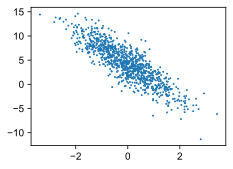

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

## 二、读取数据集

定义一个data_iter函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。每个小批量包含一组特征和标签

In [6]:
def data_iter(batch_size , features , labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #样本都是随机读取的，没有特定顺序
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
        #yield会保留当前程序执行状态，当generator每次计算需要用到上一次的计算结果，就用yield。

In [7]:
batch_size = 10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.9814, -2.1551],
        [ 0.0779, -0.1294],
        [-2.3937, -0.0819],
        [ 2.3177,  0.6676],
        [ 0.5983, -1.4059],
        [ 1.2436, -1.0597],
        [ 1.2840, -0.8659],
        [ 0.5145, -0.0664],
        [-1.0024,  0.7723],
        [ 0.0695, -1.4423]]) 
 tensor([[ 9.5550],
        [ 4.7887],
        [-0.3308],
        [ 6.5702],
        [10.1876],
        [10.2858],
        [ 9.6889],
        [ 5.4485],
        [-0.4219],
        [ 9.2172]])


## 三、初始化模型参数

在用小批量随机梯度下降优化模型参数之前，我们需要先有一些参数，我们从均值为0，标准差为0.01的正态分布中随机抽样随机数来初始化权重，偏置初始为0

In [8]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

每次更新参数都需要计算损失函数关于模型的梯度。有了这个梯度我们就可以向减小损失的方向更新每个参数。引入自动微分来计算梯度。

## 四、定义模型

In [9]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w) + b

## 五、定义损失函数

因为需要计算损失函数的梯度，我们应该先定义损失函数。使用平方损失函数。在实现中需要将真实值y的形状转换为和预测值y_hat相同

In [10]:
def square_loss(y_hat, y):
    """平方损失函数"""
    return (y_hat - y.reshape(y_hat.shape)) **2 / 2

## 六、定义优化算法

在每一步中，从数据集中随机抽取一个小批量，然后根据参数计算损失的梯度。接下来朝着减少损失的方向来更新参数。

下面的函数用于实现随机梯度下降，该函数接受模型参数集合，学习率，批量大小为输入。每一步更新的大小由学习率决定。由于计算的损失是一个批量样本的总和，所以我们用批量大小来规范化步长。

In [11]:
def sgd(params , lr , batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 七、训练

下面实现主要的训练过程。每次迭代过程我们读取小批量样本，并通过我们的模型来获得一组预测。计算完损失后，开始反向传播，存储每个参数的梯度。最后调用sgd算法来更新模型参数

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = square_loss

In [13]:
for epoch in range(num_epochs):
    for X ,y in data_iter(batch_size, features , labels):
        l = loss(net(X,w,b),y)   #X和y的小批量损失
        #因为l的形状是(batch_size,1)，而不是一个标量
        #l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b] , lr , batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.034182
epoch2,loss0.000124
epoch3,loss0.000050


由于我们使用的是自己合成的数据集，因此我们知道真实的参数是什么。因此我们可以通过比较真实参数和通过训练学习的参数来评价训练的成功程度

In [14]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([1.6177e-04, 1.0490e-05], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0003], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

#### 生成数据集

In [15]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [16]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features , labels = d2l.synthetic_data(true_w , true_b , 1000)

### 读取数据集

可以调用框架中现有的API来读取数据。将features和labels作为API的参数传递，并通过迭代器制定batch_size。此外布尔型变量is_train表示是否希望数据迭代器对象在每轮内打乱数据

In [17]:
def  load_array(data_arrays , batch_size , is_train = True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle= is_train)

In [18]:
batch_size = 10
data_iter = load_array((features,labels),batch_size)

打印第一个小批量样本。使用iter函数构造Python迭代器，并使用next函数从迭代器中获取第一项

In [19]:
next(iter(data_iter))

[tensor([[ 2.4246, -1.0614],
         [-0.7388,  0.3745],
         [ 0.7680,  1.3738],
         [ 0.2977,  1.1921],
         [ 1.6750,  0.8872],
         [ 0.8676,  0.8799],
         [-0.3671,  1.2753],
         [ 0.0981, -0.6262],
         [-0.2002, -0.2806],
         [-0.0745, -0.4269]]),
 tensor([[12.6601],
         [ 1.4651],
         [ 1.0478],
         [ 0.7526],
         [ 4.5284],
         [ 2.9310],
         [-0.8702],
         [ 6.5311],
         [ 4.7477],
         [ 5.4880]])]

### 定义模型

我们预先定义一个模型变量net，它是一个Squential类的实例。Squential类将多个层串联在一起。当给定输入数据时，Squential实例将数据传入第一层，然后第一层的输出作为第二层的输入，以此类推

在Pytorch中，全连接层在Linear类中定义.第一个参数指定输入特征的形状，第二个参数指定输出特征的形状。

In [20]:
## nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

### 初始化模型参数

我们通过net[0]来选择网络的第一层，然后使用weight.data和bias.data方法访问参数。可以使用替换方法normal_和fill_来重写参数

In [21]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

计算均方根误差使用的是MSELoss类，其也称为平方L2范数。默认情况它返回所有样本损失的平均值

In [22]:
loss = nn.MSELoss()

### 定义优化算法

Pytorch在optim模块中实现了小批量随机梯度下降的许多变体。我们实例化一个SGD实例时，我们需要指定优化的参数（可通过net.parameters（）从我们模型中获得）以及优化算法所需的超参数字典。小批量随机梯度下降只需要设置lr的值，这里为0.03

In [23]:
trainer = torch.optim.SGD(net.parameters(),lr = 0.03)

### 训练

在每一轮里，我们将完整的遍历一次数据集（train_data），不断的从中获取一个小批量的输入和一个相应的标签。对于每个小批量，我们会执行如下步骤:

1、通过调用net（X）生成预测并计算损失l。（前向传播）

2、通过反向传播来计算梯度。

3、通过调用优化器来更新模型参数。

In [24]:
num_epochs = 3
for epoch in range(num_epochs):
    for X , y in data_iter:
        l = loss(net(X), y )
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print (f'epoch{epoch+1},loss:{l:f}')

epoch1,loss:0.000200
epoch2,loss:0.000098
epoch3,loss:0.000098


In [25]:
w = net[0].weight.data
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
b = net[0].bias.data
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([ 8.8453e-05, -3.6383e-04])
b的估计误差:tensor([-9.4414e-05])


# Softmax回归

In [26]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [27]:
d2l.use_svg_display()

## 一、读取数据集

通过框架的内置函数将Fashion-MNIST数据集加载到内存中

In [28]:
#通过ToTensor实例将图像数据从PIL格式转化为32位浮点数格式
#通过除以255将所有像素归一化到0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root = '../data',train = True ,
                                                 transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root = '../data',train = False ,
                                                 transform=trans,download=True)

Fashion-MNIST数据集由10个类别组成，每个类别有训练集中的6000张图像和测试数据集中的1000张图像组成。

In [29]:
len(mnist_train),len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为28像素。数据集由灰度图像组成，通道数为1

In [30]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST数据集中含有10个类别，以下函数用于在数字标签索引以及其文本名称之间进行转换

In [31]:
def get_fashion_mnist_labels(labels):
    """返回MINIST数据集的文本标签"""
    text_labels = ['t-shirt','trouser','pullover','dress','coat',
                   'sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]


创建函数来可视化样本

In [32]:
def show_images(imgs , num_rows , num_cols , titles = None , scale = 1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale , num_rows * scale)
    _ , axes = d2l.plt.subplots(num_rows,num_cols,figsize = figsize)
    axes = axes.flatten()
    for i , (ax , img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            #图像张量
            ax.imshow(img.numpy())
        else:
            #PIL图像
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

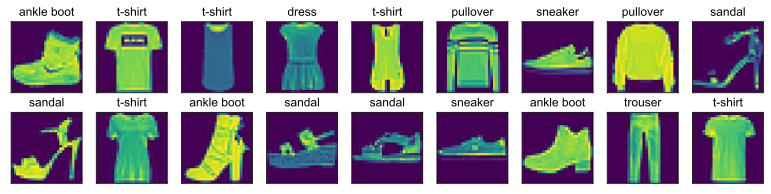

In [33]:
X,y = next(iter(data.DataLoader(mnist_train , batch_size= 18)))
show_images(X.reshape(18,28,28),2,9,titles= get_fashion_mnist_labels(y))

## 二、读取小批量

为了使得我们在读取训练集和测试集更加容易，我们使用内置的数据迭代器，而不是从零开始创建。每次迭代，数据加载器都会读取一小部分数据，批量大小为batch_size。

In [34]:
batch_size = 256
def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train , batch_size , shuffle= True,
                             num_workers= get_dataloader_workers())

查看读取训练数据所需时间

In [35]:
timer = d2l.Timer()
for X,y in train_iter:
    continue

f'{timer.stop():.2f}sec'

'1.84sec'

## 三、整合所有组件

现在定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集，这个函数返回训练集和验证集的数据迭代器。此外这个函数还接受一个可选参数resize，用于重塑图像的形状

In [36]:
def load_data_fashion_mnist(batch_size , resize = None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0 , transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data' , train= True ,transform=trans,download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data',train= False ,transform=trans,download=True
    )

    return (data.DataLoader(mnist_train , batch_size ,shuffle= True,
                            num_workers= get_dataloader_workers()),
            data.DataLoader(mnist_test,batch_size ,shuffle=False,
                            num_workers=get_dataloader_workers()))

下面通过指定resize参数来测试load_data_fashion_mnist函数的图像大小来调整功能

In [37]:
train_iter,test_iter = load_data_fashion_mnist(32,resize=64)
for X,y in train_iter:
    print(X.shape,X.dtype , y.shape,y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 四、初始化模型参数

In [38]:
from IPython import display

In [39]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

我们将展平每张图像，将他们看作为784长度的向量。在softmax回归中，输出与类别一样多。因为我们的数据集有十个类别，因此网络输出维度为10.因此权重将构成一个784x10的矩阵。偏置将构成一个1x10的行向量。我们使用正态分布初始化权重矩阵W，偏置初始化为0.

In [40]:
num_inputs = 784
num_outputs = 10
W= torch.normal(0,0.01,size = (num_inputs , num_outputs),requires_grad=True)
b = torch.zeros(num_outputs , requires_grad=True)

## 五、定义Softmax操作

softmax操作由以下几步组成

1、对每个项求幂

2、对每一项求和（小批量中的每个样本是一行），得到每个样本的规范化常数

3、将每一行除以其规范化常数，确保结果的和为1

In [41]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim = True)
    return X_exp / partition  #这里应用了广播机制

## 六、定义模型

In [42]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W) + b)

## 七、定义损失函数

In [43]:
def cross_entropy(y_hat , y):
    """交叉熵损失函数"""
    return -torch.log(y_hat[range(len(y_hat)),y])


## 八、分类精度

In [44]:
def accuracy(y_hat , y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] >1 :
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

这里定义一个实用程序类，用于对多个变量进行累加。

In [45]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self,n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a ,b in zip(self.data,args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

In [46]:
def evaluate_accuracy(net , data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module):
        net.eval() #将模型设置为评估模式
    metric = Accumulator(2)  #正确预测数、预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] /metric[1]

## 九、训练

首先定义一个函数来训练一轮


In [47]:
def train_epoch_ch3(net,train_iter,loss,updater):
    """训练模型一轮"""
    #将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    #训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            #使用Pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用用户自定义的损失函数和优化器
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


In [48]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量的绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


定义一个训练函数，它会在train_iter访问的训练数据集上训练一个模型net。该训练函数的训练轮数由num_epochs指定。在每轮结束后，利用test_iter访问的测试数据集对模型进行评估。利用Animator类来可视化训练进度

In [49]:
def train_ch3(net , train_iter , test_iter,loss,num_epochs , updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [50]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

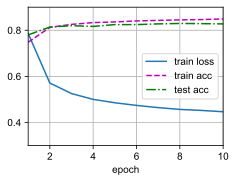

In [51]:
num_epochs  =10
train_ch3(net,train_iter , test_iter , cross_entropy , num_epochs ,updater)

## 十、预测

In [52]:
def predict_ch3(net, test_iter, n=6):
    """预测标签.

    Defined in :numref:`sec_softmax_scratch`"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

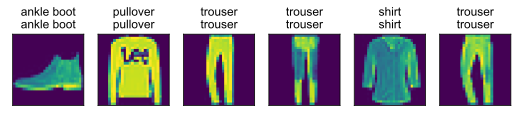

In [53]:
predict_ch3(net,test_iter)

# Softmax回归的简洁实现


In [54]:
import torch
import d2l.torch as d2l
from torch import nn

## 一、初始化模型参数

In [55]:
batch_size = 256
train_iter , test_iter = d2l.load_data_fashion_mnist(batch_size)


softmax的输出层是一个全连接层。因此为了实现模型，我们需要在Sequential中添加一个有10个输出的全连接层

In [56]:
#Pytorch 不会隐式的调整输入的形状
#因此我们在线性层前定义了展平层（flatten）来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std = 0.01)  #标准差为0.01
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 二、定义损失函数

In [57]:
loss = nn.CrossEntropyLoss(reduction='none')

## 三、定义优化算法

In [58]:
trainer = torch.optim.SGD(net.parameters(),lr = 0.1)

## 四、训练

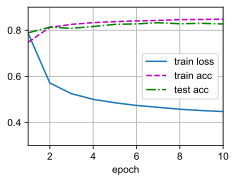

In [59]:
num_epochs = 10
d2l.train_ch3(net , train_iter , test_iter , loss ,num_epochs ,trainer)